In [2]:
import os
os.environ["MKL_NUM_THREADS"]="12" 
os.environ["NUMEXPR_NUM_THREADS"]='12'
os.environ["OMP_NUM_THREADS"]='12'
import matplotlib.pyplot as plt
import types
import numpy as np
import tqdm.notebook
import torch
from torch import optim

%matplotlib inline

from importlib import reload
import Generators, Features, Data, Likelihoods
from KernelWakeSleep import *
import Models

device = torch.device("cuda:0")
reload(Data)
reload(Models)

<module 'Models' from '/nfs/ghome/live/kevinli/Code/alws/Models.py'>

# Load true data
taken from https://github.com/wittawatj/k2abc/blob/master/code/blowfly/blowflydata.m

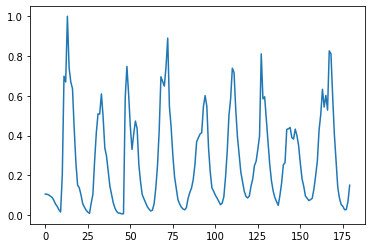

In [4]:
batch_size = 200
nsleep = 2000
nepoch = 10
nvalid = 200
torch.manual_seed(0)
np.random.seed(0)


data=torch.load("data/blowfly")[:180]
data = data/data.max()
data_mean = data.mean()
plt.plot(data)

In [5]:
def sleep(m, *args):
    return m.sample_logp(*args)

# Draw samples from initial parameters

In [6]:
T = len(data)
reload(Models)

I = torch.zeros(T)
model = Models.Ecology(  
                  P=1.0, 
                  N_0 = 1.0, 
                  z_0=0.0,  # logit(z_0)
                  s_d=1.0, 
                  s_p=1.0, 
                  tau_count=20, 
                  delta=1.0, 
                  noise_std=0.3,
                  rand_std = 0.3,
                  shift = 0.0,
                  burnin=0,
                  fit_all_z_0=True
).to(device)

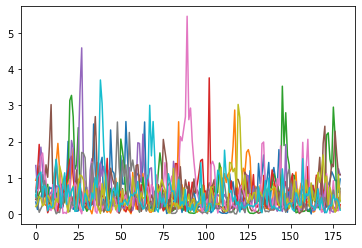

In [7]:
z, x =  model.sample(10,I, noise=0.0)
plt.plot(x.detach().cpu().numpy().T);

In [8]:
_, s = model.sample(1000, I)
# kernel_networks = [Features.lin_feat(T,100, bn=False).double()]

kernel_networks = [nn.Identity()]
s = kernel_networks[0](s)
sigma = estimate_median_distance(s) 

# choice of kernel: RFKernel for random features
kernel = RFKernel(180, sigma=sigma , lam=1e-3, nfeat=300, train_sigma=True, train_lam=True)

# or a normal Gaussian kernel (matern with p=math.inf)
# kernel = Kernel(kernel_networks, sigma , lam=1e-3, train_sigma=True, train_lam=True)

kernel.to(device)

RFKernel()

In [9]:
# optimisers for the model and gradient model
optimizer = optim.Adam(list(model.parameters()), lr=0.001)
kernel_optimizer = optim.Adam(kernel.parameters(), lr=0.001)


Elogps = []
losses = []

log_lams = []
log_sigmas = []

network_norms = []
kernel_network_norms = []
kernel_network_feat_norms = []
noise_stds = []
rand_stds = []

network_grad_norms = []


record_dict = dict()
param_names = ["P", "N_0", "z_0", "s_d", "s_p", "tau_logits", "delta", "noise_std", "rand_std"]

for pn in param_names:
    record_dict[pn] = []

In [ ]:
import gc
gc.collect()

model.train()
kernel.train()
nsleep = 3000


with tqdm.notebook.tqdm(range(50000)) as t:
    for ei in t:
        
#         model.noise_std.data.clamp_(torch.tensor(np.log(0.1)))

        X_tr = data[None,:].to(device)

        data_0, data_1, norm, nat = sleep(model, nsleep, I)
        data_0_val, data_1_val, norm_val, nat_val = sleep(model, nsleep // 10, I)
        S_val = model.suff(data_1_val)
        
        if ei % 1 == 0:

            kernel_optimizer.zero_grad()

            Elogp_val = KRR_2(model.suff, kernel, data_1_val, data_1, norm.detach(), nat.detach()).mean()
            logp_true= (nat_val * S_val).sum(-1) - norm_val 
            loss_val = torch.mean((Elogp_val - logp_true )**2)

            loss_val.backward(retain_graph=True)
#             torch.nn.utils.clip_grad_norm_(kernel.parameters(), 1e1)

            kernel_optimizer.step()

            network_grad_norm = sum(map(lambda x: (x.grad**2).sum() if x.grad is not None else 0, kernel.parameters()))

            losses += loss_val.detach().cpu().numpy(),

            log_lams += kernel.log_lam.cpu().detach().numpy().copy(),
            log_sigmas += kernel.log_sigma.cpu().detach().numpy().copy(),

        Elogp = KRR_2(model.suff, kernel, X_tr, data_1, norm, nat).mean()
        network_norm = sum(map(lambda x: (x**2).sum(), model.parameters()))

        gen_loss = -Elogp 

        Elogps += Elogp.mean().detach().cpu().numpy(),

        optimizer.zero_grad()
        gen_loss.backward(retain_graph=False)

        network_norms += network_norm,
        network_grad_norm = sum(map(lambda x: (x.grad**2).sum() if x.grad is not None else 0, model.parameters()))
        network_grad_norms += network_grad_norm,
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1e1)

        optimizer.step()
        t.set_postfix(Elogp=Elogp.item())

        for pn in param_names:
            param_value = getattr(model, pn)
            if pn in ["tau_logits"]:
                param_value = torch.softmax(param_value, 0)
            elif pn == "z_0":
                param_value = torch.sigmoid(param_value)
            else:
                param_value = param_value.exp()
            record_dict[pn].append(param_value.detach().cpu().numpy())

        noise_stds += model.noise_std.exp().detach().cpu().numpy(),
        rand_stds  += model.rand_std.exp().detach().cpu().numpy(),

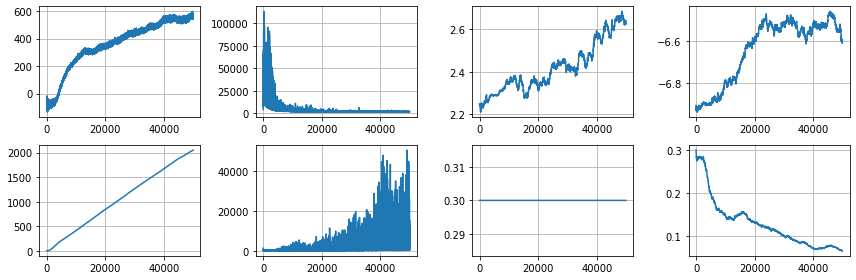

In [38]:
params = [Elogps,losses, log_sigmas, log_lams, 
          network_norms, network_grad_norms, noise_stds, rand_stds]

nplot = len(params)
fig, axes = plt.subplots(2,4, figsize=(12,4), sharex=False)
axes = np.ravel(axes)
for i in range(nplot):
    axes[i].plot(params[i])
    axes[i].grid(True)
# axes[0].set_xlim([20000,2000])
fig.tight_layout()

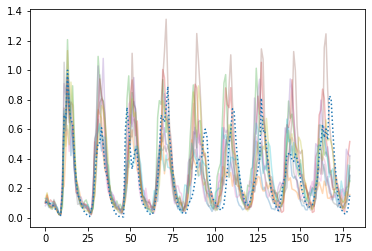

In [37]:
_, x = model.sample(10,I,noise=None)
plt.plot(x.detach().cpu().numpy().T, alpha=0.3)
plt.plot(data.cpu().numpy().T, ':');

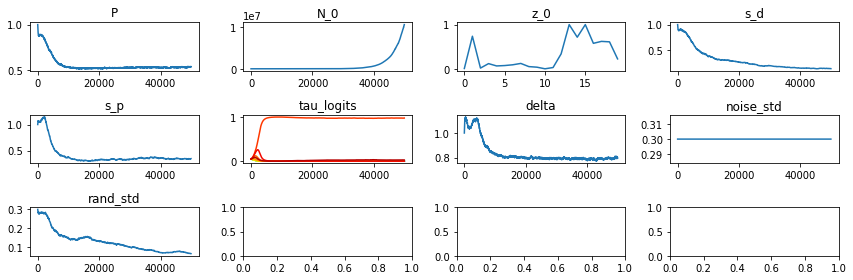

In [40]:
fig, axes = plt.subplots(3,4, figsize=(12,4))
axes = np.reshape(axes,-1)
length = 50000
for pi, pn in enumerate(param_names):
    ax = axes[pi]
    
    if pn == "z_0" and record_dict["z_0"][0].ndim==1:
        ax.plot(record_dict[pn][-1])
    elif pn == "tau_logits":
        ntau = len(model.tau_logits)
        lines = np.asarray(record_dict[pn][-length:])
        for i in range(ntau):
            ax.plot(lines[:,i], color = plt.get_cmap("jet")(i / ntau ))
#     elif pn in ["noise_std", "rand_std"]:
#         ax.plot(np.log(record_dict[pn][-length:]))
    else:
        ax.plot(record_dict[pn][-length:])
    ax.set_title(pn)
plt.tight_layout()

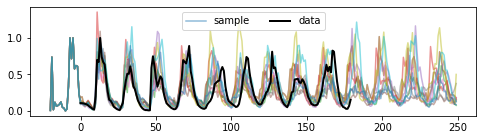

In [49]:
torch.manual_seed(2)

tau_count = 20
length = 250
I_test = torch.zeros(length)
z, x = model.sample(10, I_test, 0, )
data_np = data.cpu().numpy()


z = z[3].detach().cpu().numpy()
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(range(-tau_count,length),z[0].T, alpha=0.5, label="sample")
ax.plot(range(-tau_count,length),z.T, alpha=0.5);
ax.plot(data_np.T-0, 'k',lw=2, label="data");
ax.legend(ncol=2,)

Use the blocks below to save and load models 

```
torch.save([I, model.state_dict(), kernel.state_dict(), optimizer.state_dict(), kernel_optimizer.state_dict(), record_dict], "models/kws/eco_rf")
I, ms, ks, os, kos, rd = torch.load("models/kws/eco_good")
model.load_state_dict(ms)
kernel.load_state_dict(ks)
optimizer.load_state_dict(os)
kernel_optimizer.load_state_dict(kos)
record_dict = rd
```